# Supplementary Figures

## Move this to separate script/module

In [1]:
# Standard Libraries
import os
import sys
from collections import OrderedDict

# Numerical & Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.legend_handler import HandlerTuple
from matplotlib.pyplot import gcf
import seaborn as sns
from matplotlib import gridspec

# Scientific Libraries
import reframed
from reframed.cobra import auxotrophy
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
from sklearn.metrics.pairwise import pairwise_distances
import scipy.stats as stats

# Custom Functions
sys.path.append("../functions_steadiercom/")
sys.path.append("../functions/")

import steadiercom_samples_plotting
import steadiercom_samples_preprocessing as steadiercom_pre
import steadiercom_samples_processing as preprocessing_func
import supplementary_process_data as process_data
import supplementary_plotting
import general_functions as general_func
import colors_community
import colors_MAGs as color_func


In [2]:
%load_ext autoreload
%autoreload 2

**Dict for community id to community name**

In [3]:
communityid2name_dict = {"CD_A":"Compost digestate - Avicel",
"CD_P":"Compost digestate - PASC",
"CD_X":"Compost digestate - Xylan",
"CM_A":"Cow manure - Avicel",
"CM_P":"Cow manure - PASC",
"CM_X":"Cow manure - Xylan",
"M_P":"Marshland soil - PASC",
"M_X":"Marshland soil - Xylan",
}

**Load annotations for MAGs**

In [4]:
all_mags_paper = general_func.read_allmags_data()
all_mags_paper_reduced,total_members_genus = general_func.all_mags_paper_genus(all_mags_paper,prefix=True)
all_mags_paper_reduced,total_members_family = general_func.all_mags_paper_family(all_mags_paper_reduced,prefix=True,combine=False)

**Calculate relative abundance**

In [5]:
total_coverage = all_mags_paper_reduced[all_mags_paper_reduced.new_coverage>1].groupby(["Source","Substrate"]).sum()["new_coverage"]

all_mags_paper_reduced_copy =all_mags_paper_reduced[all_mags_paper_reduced.new_coverage>1].copy()
all_mags_paper_reduced_copy["relative_abundance"] = all_mags_paper_reduced_copy.apply(lambda x:x.new_coverage/total_coverage[(x.Source,x.Substrate)]*100,axis=1)
all_mags_paper_reduced_copy.groupby(["Source","Substrate"]).sum()["relative_abundance"]


Source             Substrate
Compost_Digestate  Avicel       100.0
                   PASC         100.0
                   Xylan        100.0
Cow_Manure         Avicel       100.0
                   PASC         100.0
                   Xylan        100.0
Marshland          PASC         100.0
                   Xylan        100.0
Name: relative_abundance, dtype: float64

**Load and run initial processing of steadiercom data**

In [6]:
SC1_C = pd.read_csv("../output_30_08_24/steadiercom_sample_0.1.3/results/results_99_SC1_C.tsv",sep="\t")
SC2_C = pd.read_csv("../output_30_08_24/steadiercom_sample_0.1.3/results/results_99_SC2_C.tsv",sep="\t")
SC1_X = pd.read_csv("../output_30_08_24/steadiercom_sample_0.1.3/results/results_99_SC1_X.tsv",sep="\t")

steadier_sample = pd.concat([SC1_C,SC2_C,SC1_X])

# SteadierCom data should be given in mg
steadier_sample = steadier_sample[(steadier_sample.rate>1e-6)].copy()
steadier_sample.mass_rate = steadier_sample.mass_rate*1000

In [7]:
steadier_sample = process_data.process_data(steadier_sample,all_mags_paper_reduced=all_mags_paper_reduced)

**Load models**

In [8]:
model_uni = reframed.load_cbmodel("../input/universe_bacteria.xml")


In [9]:
GEMs_dict = {}

directory = os.fsencode("../output_30_08_24/GEMs/GEMs_final/")

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    print(filename)

    GEMs_dict[filename[:-4]]= reframed.load_cbmodel("../output_30_08_24/GEMs/GEMs_final/"+filename)


CH7-bin.18.xml
CH15-bin.7.xml
CH13-bin.0.xml
CH1-bin.4.xml
CH13-bin.1.xml
CH13-bin.11.xml
CH15-bin.6.xml
CH7-bin.2.xml
CH13-bin.13.xml
CH1-bin.10.xml
CH1-bin.6.xml
CH13-bin.2.xml
CH13-bin.12.xml
CH15-bin.5.xml
CH7-bin.1.xml
CH15-bin.1.xml
CH1-bin.3.xml
CH13-bin.17.xml
CH15-bin.0.xml
CH7-bin.4.xml
CH7-bin.23.xml
CH7-bin.6.xml
CH15-bin.22.xml
CH15-bin.2.xml
CH1-bin.1.xml
CH13-bin.4.xml
CH13-bin.14.xml
CH15-bin.23.xml
CH7-bin.20.xml
CH8-bin.8.xml
CH8-bin.9.xml
CH8-bin.25.xml
CH14-bin.4.xml
CH14-bin.1.xml
CH14-bin.0.xml
CH8-bin.21.xml
CH14-bin.2.xml
CH8-bin.22.xml
CH8-bin.2.xml
CH8-bin.29.xml
CH8-bin.7.xml
CH8-bin.6.xml
CH3-bin.2.xml
CH8-bin.14.xml
CH8-bin.16.xml
CH3-bin.0.xml
CH8-bin.5.xml
CH3-bin.1.xml
CH8-bin.17.xml
CH7-bin.11.xml
CH9-bin.1.xml
CH15-bin.12.xml
CH13-bin.25.xml
CH15-bin.13.xml
CH9-bin.0.xml
CH7-bin.12.xml
CH9-bin.2.xml
CH7-bin.9.xml
CH15-bin.10.xml
CH7-bin.8.xml
CH7-bin.13.xml
CH7-bin.17.xml
CH15-bin.8.xml
CH15-bin.15.xml
CH7-bin.16.xml
CH9-bin.6.xml
CH9-bin.4.xml
CH15-bi

## Production

### Production and realease to environment - community wise

In [10]:
cmap = colors_community.cmap_community()
cmap_lut = dict(zip(sorted(steadier_sample.community.unique()),cmap.colors))

**Process data**

In [11]:
steadier_sample_bar = steadier_sample.copy()
steadier_sample_production = steadier_sample_bar[steadier_sample_bar.receiver=="environment"].copy()
steadier_sample_production["community"]=steadier_sample_production["community"].map(lambda x:communityid2name_dict[x])
cmap_local = colors.ListedColormap([cmap_lut[community] for community in communityid2name_dict.keys()])

**Inner plot**

In [12]:
steadier_sample_production = steadier_sample_production[steadier_sample_production.compound.isin(["Acetic acid","CO2","L-Lactic acid","Ethanol","Formic acid","Isobutyric acid","Propionic acid","Butyric acid","Caproic acid","Hydrogen"])]
steadier_sample_prod_plot_df = steadier_sample_production.groupby(["community","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0).T
steadier_prod_sum = steadier_sample_prod_plot_df.sum(axis=1)
sorter = steadier_prod_sum.sort_values().index
steadier_sample_prod_plot_df = steadier_sample_prod_plot_df.loc[sorter]

steadier_sample_prod_plot_df.plot(kind="bar",cmap=cmap_local,fontsize=12, rot=90,legend=False)
plt.xlabel('')
plt.savefig("Figures/comm_prod_temporary.png",bbox_inches='tight')
plt.close()

**Outer plot**

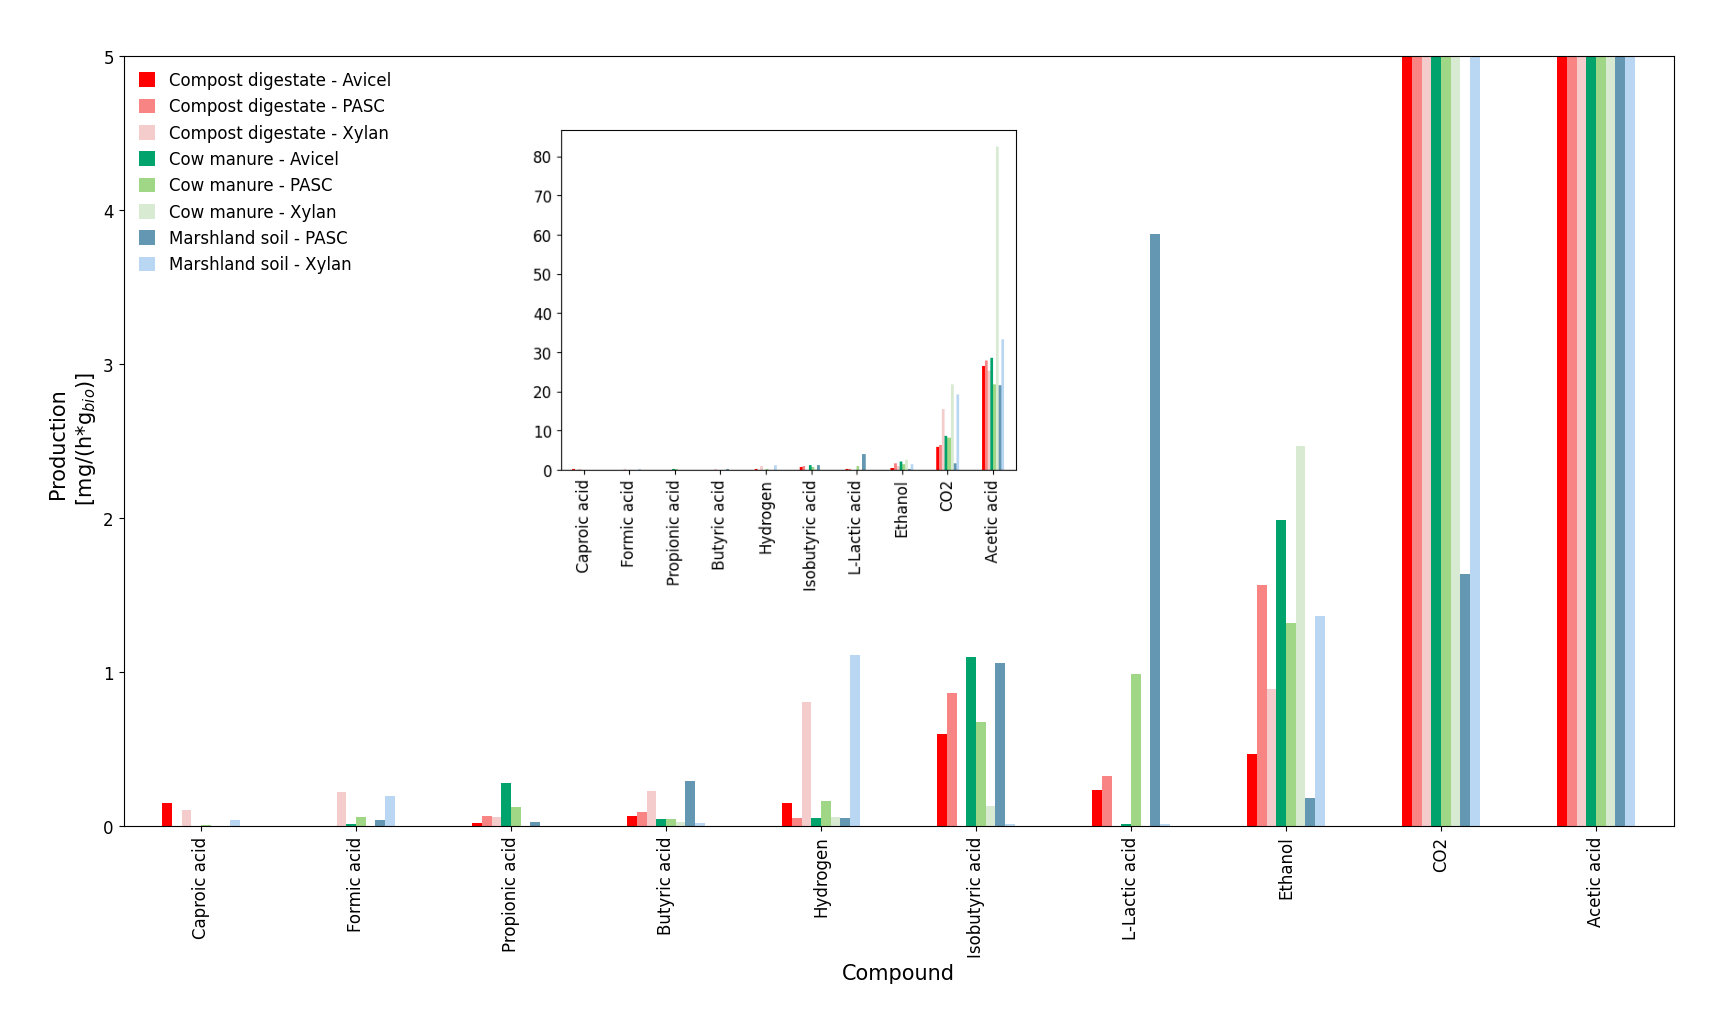

In [13]:
fig, ax = plt.subplots()
im = plt.imread("Figures/comm_prod_temporary.png")



steadier_sample_prod_plot_df.plot(ax=ax,kind="bar",figsize=(20,10),cmap=cmap_local,fontsize=12, rot=90,ylim=[0,5])
plt.legend(fontsize=12)
plt.xlabel('Compound', fontsize=15)
plt.ylabel('Production \n [mg/(h*g$_{bio}$)]', fontsize=15)

# Add inner axis
newax = fig.add_axes([0.2, 0.3, 0.5, 0.55], zorder=10)
newax.imshow(im)
newax.axis('off')


plt.savefig("Figures/community_production_bar.png",bbox_inches='tight',dpi=300)
plt.show()

In [14]:
steadier_sample_bar = steadier_sample.copy()
steadier_sample_production = steadier_sample_bar[steadier_sample_bar.receiver=="environment"].copy()
steadier_sample_production["community"]=steadier_sample_production["community"].map(lambda x:communityid2name_dict[x])
cmap_local = colors.ListedColormap([cmap_lut[community] for community in communityid2name_dict.keys()])

### Production - clustermaps

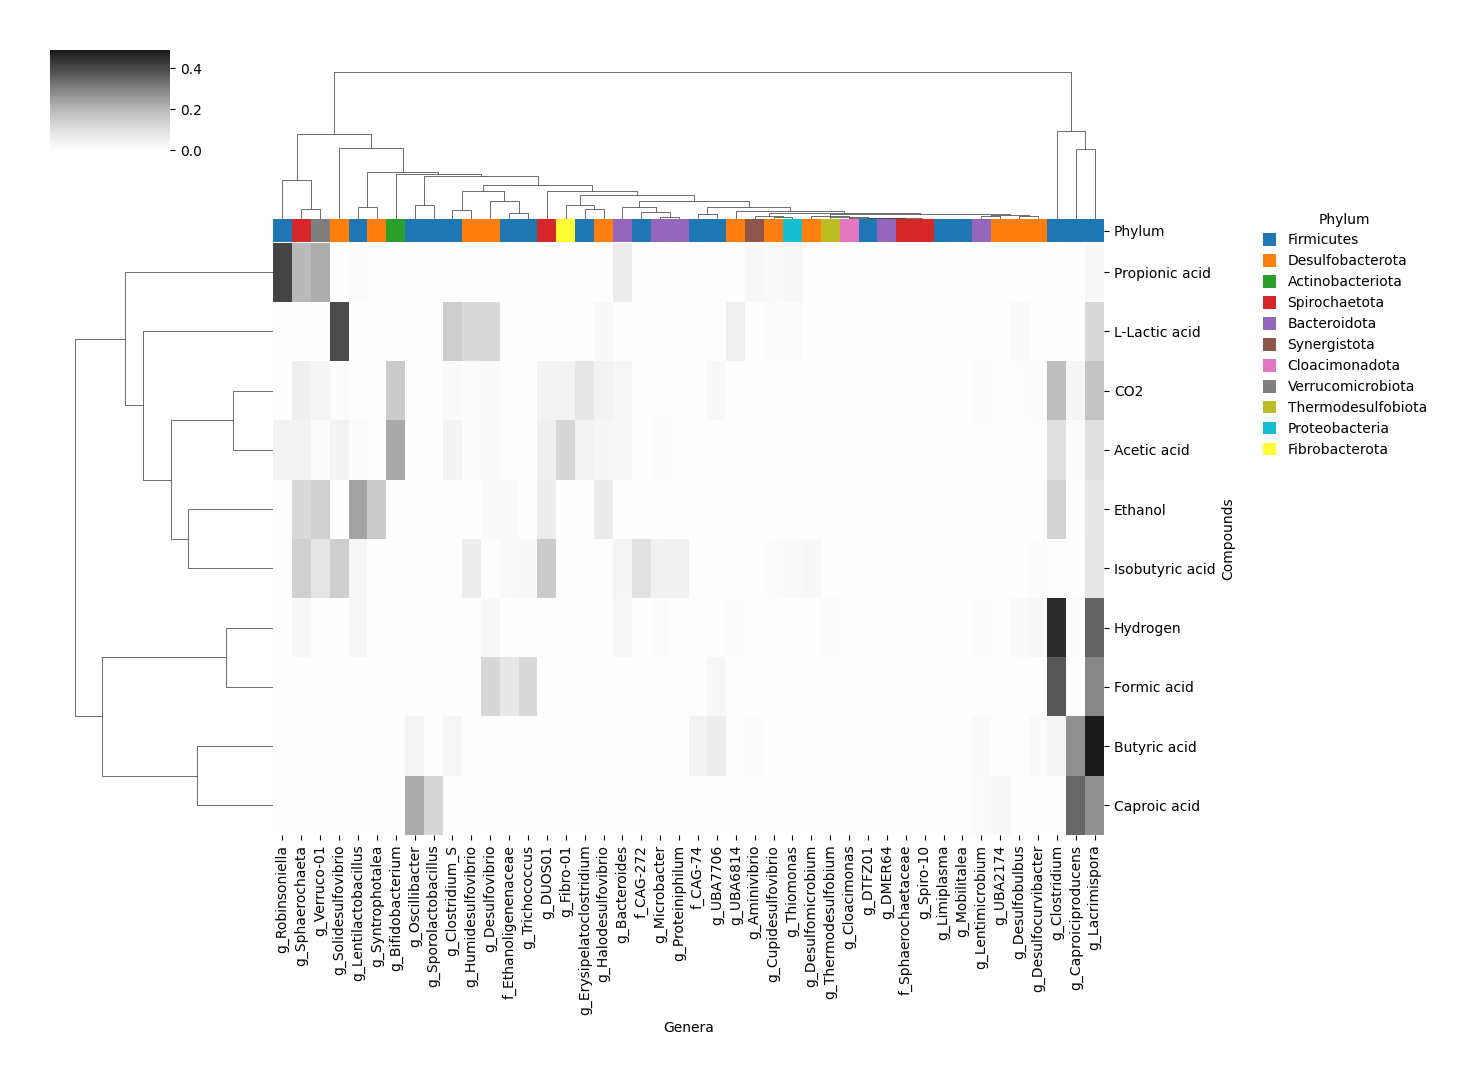

In [15]:
color_df,relevant_phyla,phyla_lut = process_data.phylum_colors_spec(steadier_sample,all_mags_paper_reduced=all_mags_paper_reduced)

steadier_sample_not_from_env = steadier_sample[steadier_sample.donor!="environment"].copy()
steadier_sample_prod_overview = steadier_sample_not_from_env.groupby(["genus_donor","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)
# Missing 1-propanol
steadier_sample_prod_overview.index.name="Genera"
steadier_sample_prod_overview.columns.name="Compounds"
steadier_sample_prod_overview = steadier_sample_prod_overview[["CO2","Hydrogen","Acetic acid","Ethanol","Propionic acid","Butyric acid","L-Lactic acid","Formic acid","Caproic acid","Isobutyric acid"]]
steadier_sample_prod_overview = steadier_sample_prod_overview/steadier_sample_prod_overview.sum()

fig = sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True,
               xticklabels=True,
              figsize=(12,10),
              cbar_pos=(0,0.9,0.1,0.1))

for label in relevant_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)


fig.savefig("Figures/clustermap_prod_env_and_others.png",bbox_inches='tight',dpi=300)

## Interactions

In [16]:
steadier_sample_cross = steadier_sample[(steadier_sample.donor!="environment") & (steadier_sample.receiver!="environment")]

steadier_sample_cross = steadier_sample_cross[steadier_sample_cross.frequency>0.1]

### Interactions - community wise

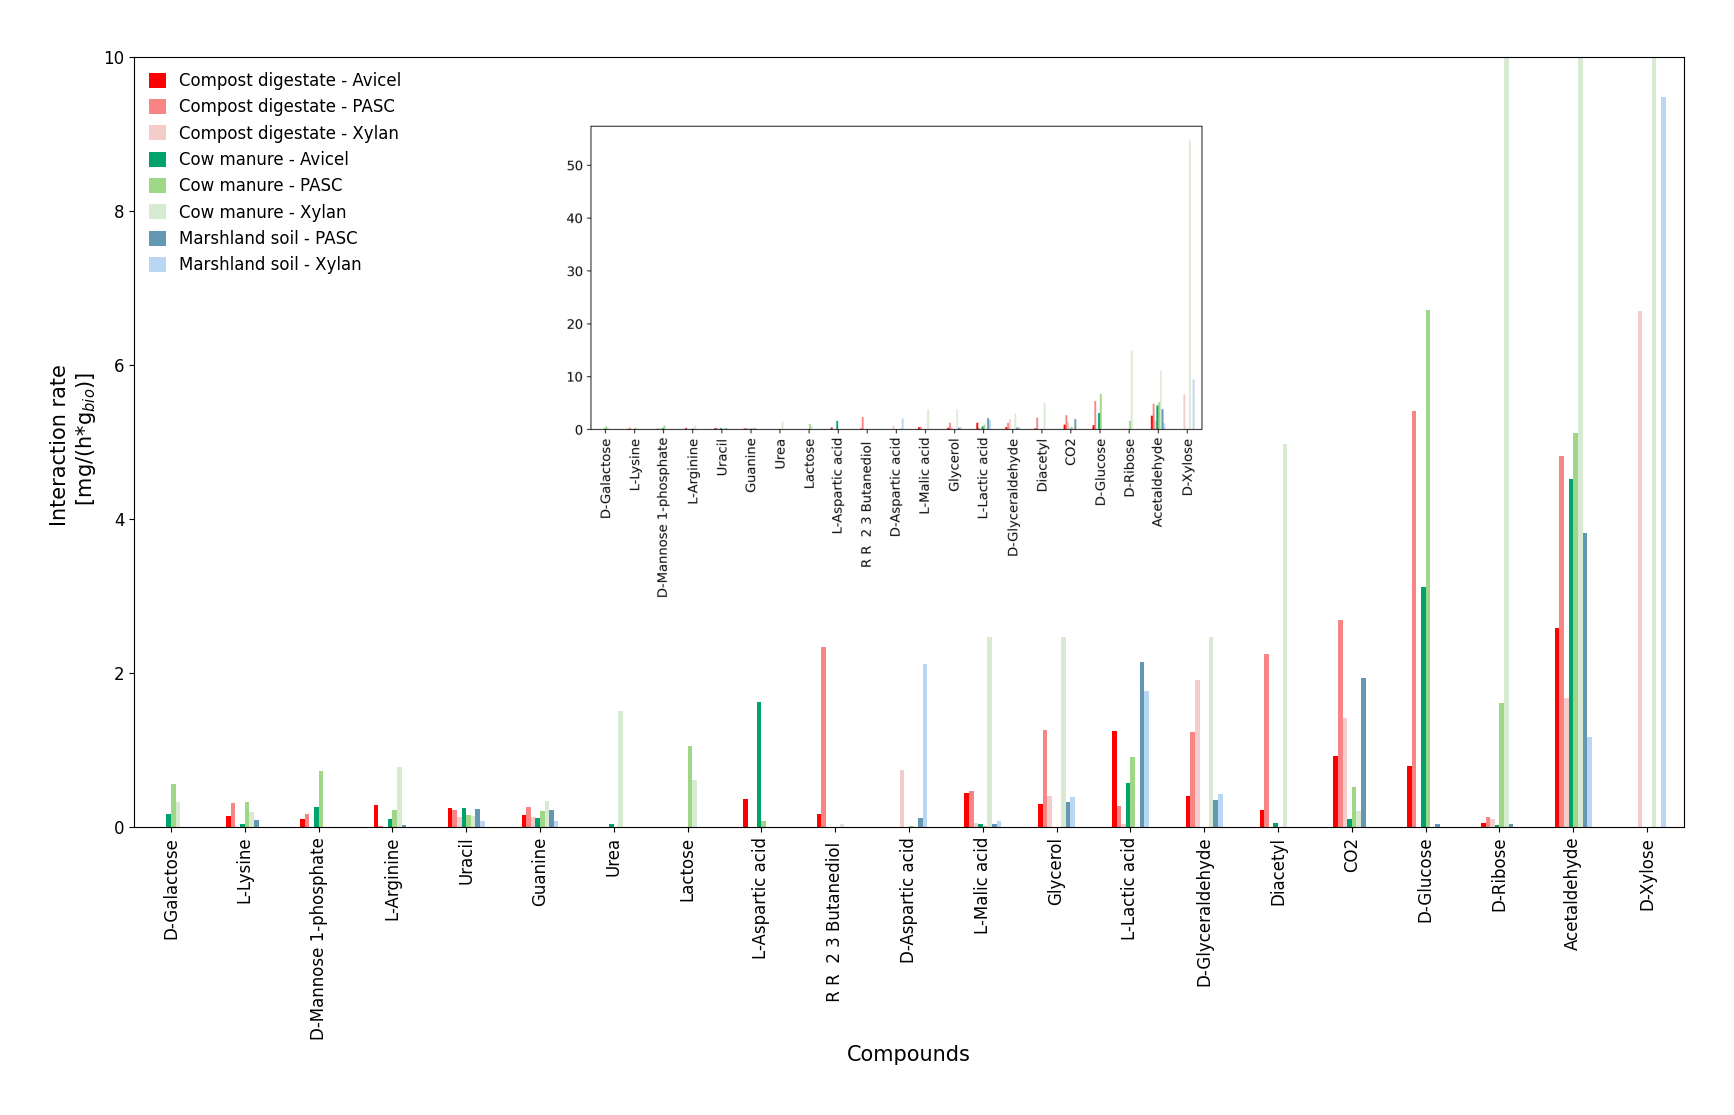

In [17]:
steady_com_count_for_plot = supplementary_plotting.plot_interactions(steadier_sample_cross,
                                                                     cmap_lut=cmap_lut,
                                                                     min_number=1.0,
                                                                     fig_title="all",
                                                                     ylim_top=10)

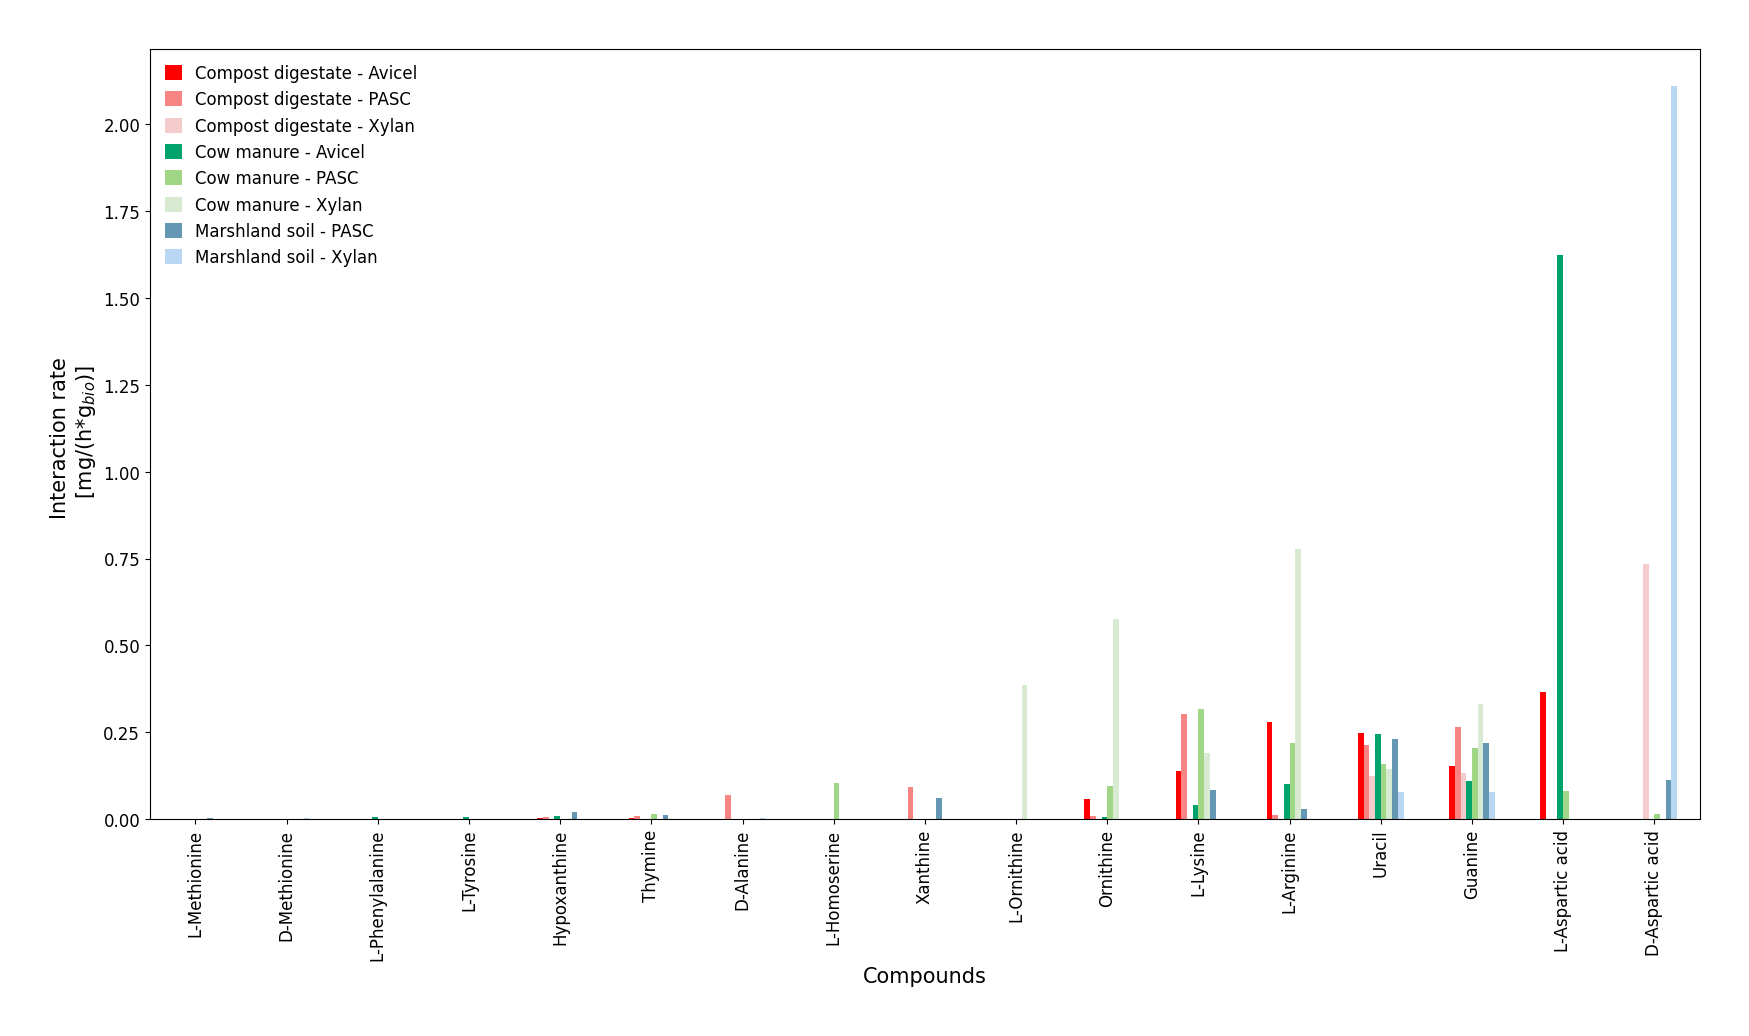

In [18]:
steady_com_count_for_plot = supplementary_plotting.plot_interactions(steadier_sample_cross,cmap_lut=cmap_lut,
                                               interesting_superclasses=["nucleotides and derivatives",
                                                                         "amino acids and derivatives",
                                                                         "B-vitamins","urea and derivatives",
                                                                         "cofactors"],
                                               fig_title="special_compounds", 
                                               ylim_top=1,
                                               inset_plot=False)

## Auxotrophies in compost digestate on Xylan

In [19]:
MAG2community_id = pd.read_csv("../output_30_08_24/MAG2community_id.tsv",sep="\t",header=None)
MAG2community_id.columns=["MAG","community_id"]

##### Load models

In [20]:
CD_X_MAGs = MAG2community_id[MAG2community_id.community_id=="CD_X"].MAG.values
GEMs_dict2 = {}
for MAG in CD_X_MAGs:
    GEMs_dict2[MAG]=GEMs_dict[MAG].copy()

**Find auxotrophies**

In [21]:
media_db = pd.read_csv("https://raw.githubusercontent.com/cdanielmachado/carveme/master/carveme/data/input/media_db.tsv",sep="\t")
lb_db = media_db[media_db.medium=="LB[-O2]"]
m9_env_db = media_db[media_db.medium=="M9[-O2]"]
m9_env = reframed.Environment.from_compounds(m9_env_db.compound.values)
lb_env = reframed.Environment.from_compounds(lb_db.compound.values)
lb_env["R_EX_gua_e"]=(-1000,0)

all_gems_auxo={}

for MAG in GEMs_dict2.keys():
    model = GEMs_dict2[MAG]
    
    lb_env.apply(model,inplace=True,warning=False)
    specific_env = reframed.Environment.from_model(model)
    
    auxo = auxotrophy.auxotrophies(model,specific_env)
    
    all_gems_auxo[MAG]=auxo

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-27


**Process results + map identifiers to names and clean metabolite names**

In [22]:
summary_auxo = {}

for key,value in all_gems_auxo.items():
    summary_auxo[key]={}
    for rxn in value:
        summary_auxo[key][rxn]=1
summary_auxo_df = pd.DataFrame(summary_auxo).fillna(0)
summary_auxo_df = summary_auxo_df.loc[~summary_auxo_df.index.isin(["R_EX_"+met+"_e" for met in m9_env_db.compound.values])]

rxn2met = {rxn:model_uni.reactions[rxn].get_substrates()[0] for rxn in model.reactions if rxn.startswith("R_EX_")}
rxn2met["R_EX_nac_e"] = "M_nac_e"
rxn2met["R_EX_pnto__R_e"] = "M_pnto__R_e"
rxn2met["R_EX_ins_e"] = "M_ins_e"
rxn2met["R_EX_adn_e"] = "M_adn_e"
rxn2met["R_EX_gsn_e"] = "M_gsn_e"
rxn2met["R_EX_cmp_e"] = "M_cmp_e"

summary_auxo_df.index = summary_auxo_df.index.map(lambda x: model_uni.metabolites[rxn2met[x]].name)
summary_auxo_df.index = summary_auxo_df.index.map(lambda x: x.replace(" C17H20N4O6",""))

genus_groups,mag2genus_dict = general_func.mag2genus(all_mags_paper_reduced)
summary_auxo_df.columns = summary_auxo_df.columns.map(lambda x:mag2genus_dict[x])

**Plot results**

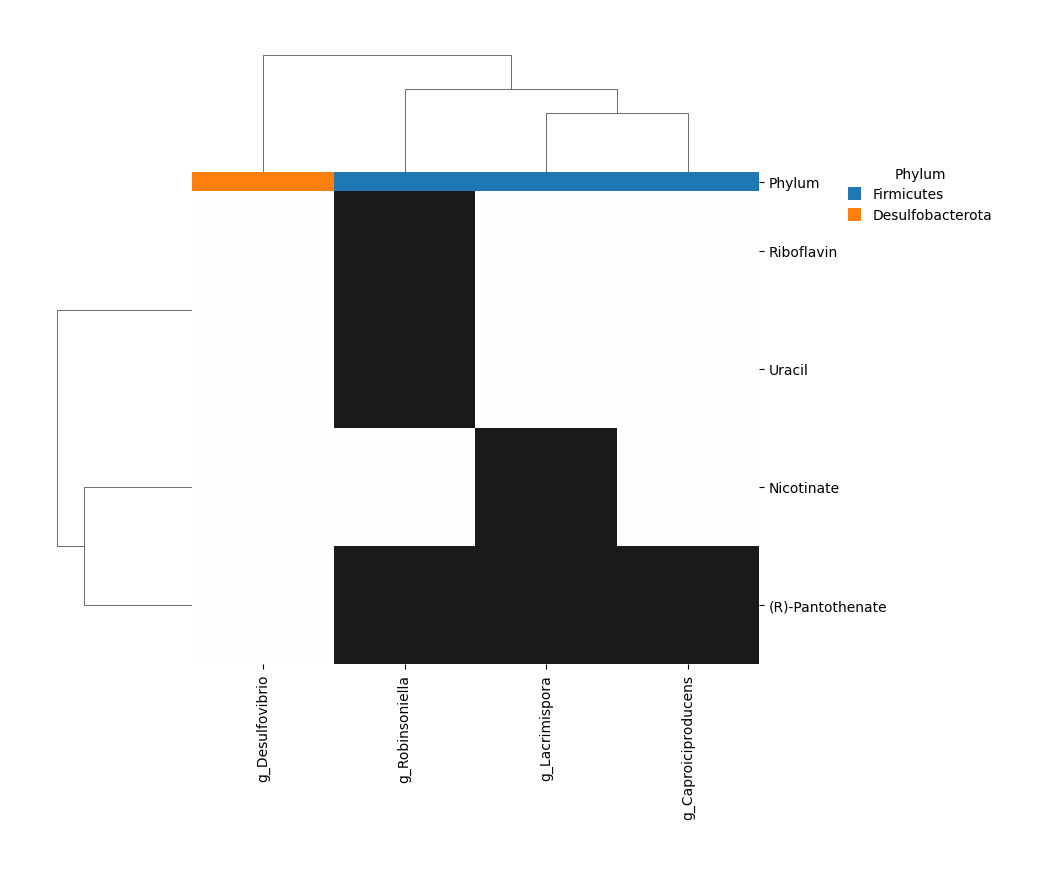

In [23]:
colrs_df,phyla_specific,phyla_lut = process_data.color_df_auxotrophies(CD_X_MAGs,all_mags_paper_reduced)

fig = sns.clustermap(data=summary_auxo_df, 
               cmap="RdGy",
               center=0,
               method="average",
               metric="jaccard",
               col_colors=colrs_df,
               z_score=None,
               cbar_pos=None,
               standard_scale=None,
               xticklabels=True,
               yticklabels=True,
               figsize=(8,8)             )
plt.setp(fig.ax_heatmap.get_yticklabels(),rotation=360) 


for label in phyla_specific:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)

fig.savefig("Figures/auxotrophies_CD_X.png",bbox_inches='tight',dpi=300)

### Oligosaccharide consumption - gene-reaction-metabolite relationship

In [24]:
cellulose=["M_cell3_c","M_cell4_c","M_cell5_c"]

xylan = ["M_xyl3_c","M_xyl4_c","M_xylan4_c","M_xylan8_c"]

# for model in GEMs_dict
has_oligo_degr_potential = {}
for MAG,model in GEMs_dict.items():
    has_genes = []
    has_metabolites = []

    for met in cellulose+xylan:
        # Check if metabolite is in model
        if met in model.metabolites:
            has_metabolites.append(met)
            
            # Find associated reactions
            reactions = model.get_metabolite_reactions(met)
            for rxn in reactions:
                # Check gene annoations for each reactions
                if model.reactions[rxn].gpr:
                    genes = list(model.reactions[rxn].gpr.get_genes())
                    has_genes.extend(genes)
        else:
            continue
    # Summarize number of relevant metabolites and genes for associated reactions
    has_oligo_degr_potential[MAG]={"number_metabolites":len(set(has_metabolites)),"number_genes":len(set(has_genes))}
    

/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


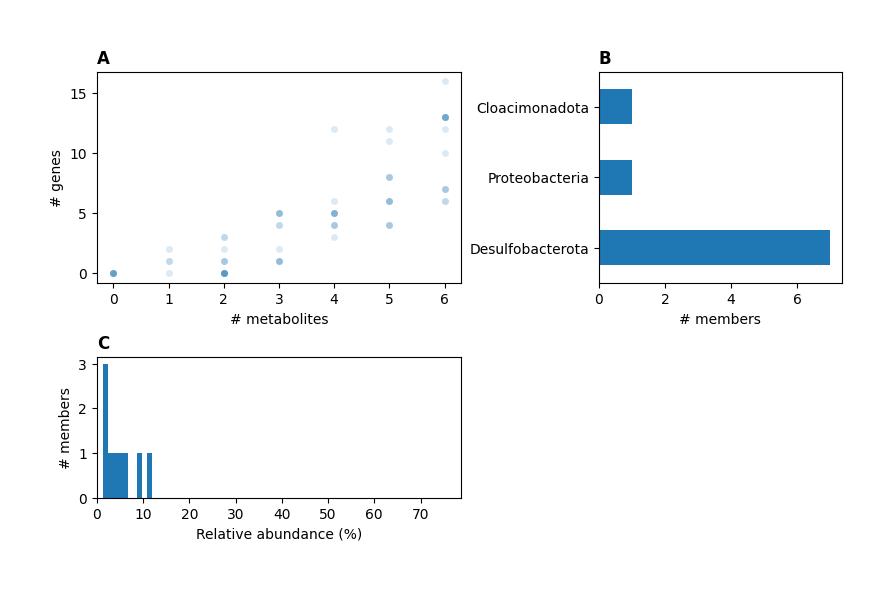

In [25]:
fig2 = plt.figure(constrained_layout=True,figsize=(8,5))
spec2 = gridspec.GridSpec(ncols=5, nrows=5, figure=fig2)
ax1 = fig2.add_subplot(spec2[0:3, 0:3])
ax2 = fig2.add_subplot(spec2[0:3, 3:])
ax3 = fig2.add_subplot(spec2[3:, 0:3])

degr_potential_df =pd.DataFrame(has_oligo_degr_potential).T

ax1 = degr_potential_df.plot(ax=ax1,kind="scatter",
                       x="number_metabolites",
                       y="number_genes",
                       marker="o",
                       s=25,
                       alpha=0.15)

ax1.set_xlabel("# metabolites")
ax1.set_ylabel("# genes")
ax1.set_title("A",loc="left",fontdict={"fontsize": 12, "weight": "bold"})

has_met_no_gene = degr_potential_df[(degr_potential_df.number_metabolites>0) & (degr_potential_df.number_genes==0)].index
ax2 = all_mags_paper_reduced_copy.loc[has_met_no_gene]["Phylum"].value_counts().plot.barh(ax=ax2)
ax2.set_xlabel("# members")
ax2.set_title("B",loc="left",fontdict={"fontsize": 12, "weight": "bold"})


ax3 =all_mags_paper_reduced_copy.loc[has_met_no_gene]["relative_abundance"].plot.hist(ax=ax3)
ax3.set_xlabel("Relative abundance (%)")
ax3.set_ylabel("# members")
ax3.set_title("C",loc="left",fontdict={"fontsize": 12, "weight": "bold"})
ax3.set_xlim([0,all_mags_paper_reduced_copy.relative_abundance.max()])
plt.savefig("Figures/oligosaccharide_genes.png",bbox_inches='tight')

In [26]:
all_mags_paper_reduced_copy.loc[has_met_no_gene][["Source","Substrate","Phylum","Genus","relative_abundance"]]\
    .sort_values("relative_abundance",ascending=False)\
    .head(5)

,Source,Substrate,Phylum,Genus,relative_abundance
CH13-bin.11,Compost_Digestate,Avicel,Desulfobacterota,g_Desulfovibrio,11.846751
CH7-bin.16,Cow_Manure,PASC,Desulfobacterota,g_Humidesulfovibrio,9.739621
CH15-bin.22,Compost_Digestate,PASC,Desulfobacterota,g_Syntrophotalea,6.152125
CH15-bin.6,Compost_Digestate,PASC,Desulfobacterota,g_Desulfovibrio,5.050355
CH7-bin.18,Cow_Manure,PASC,Desulfobacterota,g_Desulfobulbus,3.913182


### Interactions - Consumption frequency and relative abundance

In [27]:
steadiercom_samples_inter = steadier_sample[(steadier_sample.donor!="environment") &\
                                                             (steadier_sample.receiver!="environment")].copy()



**Get average frequency of consumption for each member based on specific compound class**

In [28]:
## All compounds
interaction_strength_all = steadiercom_samples_inter[["receiver","frequency"]].groupby(["receiver"]).mean().sort_values("frequency")
interaction_strength_all["relative_abundance"]=interaction_strength_all.index.map(lambda x: all_mags_paper_reduced_copy.loc[x,"relative_abundance"])

steadiercom_samples_inter = steadier_sample[(steadier_sample.donor!="environment") &\
                                                             (steadier_sample.receiver!="environment")].copy()
## Carboxylic acids
interaction_strength_carbox = steadiercom_samples_inter[steadiercom_samples_inter.super_class.isin(["carboxylic acids and anions"
                                                                                                  ])]
interaction_strength_carbox = interaction_strength_carbox[["receiver","frequency"]].groupby(["receiver"]).mean().sort_values("frequency")
interaction_strength_carbox = interaction_strength_carbox.reindex(interaction_strength_all.index).fillna(0)
interaction_strength_carbox["relative_abundance"] = interaction_strength_all["relative_abundance"]

## Alcohols and aldehydes
interaction_strength_alcohol = steadiercom_samples_inter[steadiercom_samples_inter.super_class.isin(["alcohols and aldehydes"
                                                                                                  ])]
interaction_strength_alcohol = interaction_strength_alcohol[["receiver","frequency"]].groupby(["receiver"]).mean().sort_values("frequency")
interaction_strength_alcohol = interaction_strength_alcohol.reindex(interaction_strength_all.index).fillna(0)
interaction_strength_alcohol["relative_abundance"] = interaction_strength_all["relative_abundance"]

## Amino acids and nucleotides
interaction_strength_amino = steadiercom_samples_inter[steadiercom_samples_inter.super_class.isin(["amino acids and derivatives",
                                                                                                  "nucleotides and derivatives"
                                                                                                  ])]
interaction_strength_amino = interaction_strength_amino[["receiver","frequency"]].groupby(["receiver"]).mean().sort_values("frequency")
interaction_strength_amino = interaction_strength_amino.reindex(interaction_strength_all.index).fillna(0)
interaction_strength_amino["relative_abundance"] = interaction_strength_all["relative_abundance"]


**Plot figure**

/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


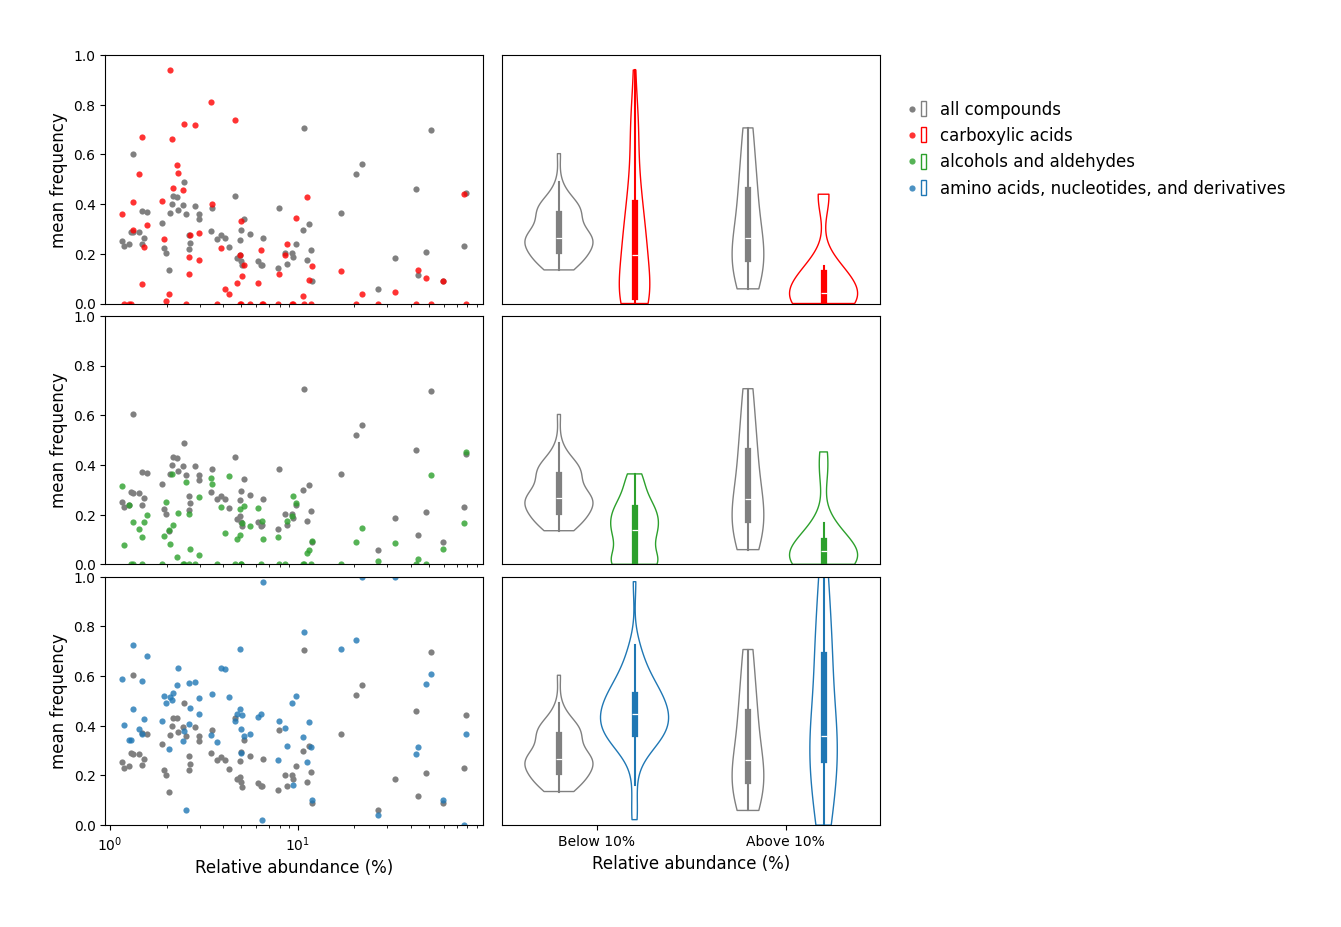

In [29]:
fig,axes = plt.subplots(3,2,figsize=(10,10))

axes[0,0],axes[0,1],handles1,labels1 = supplementary_plotting.make_receiver_frequency_plots(axes[0,0],axes[0,1],interaction_strength_carbox,interaction_strength_all,class_name="carboxylic acids")
axes[0,0].set_xticks([])
axes[0,0].set_xlabel("")
axes[0,1].set_xticks([])
axes[0,1].set_xlabel("")
axes[0,1].set_yticks([])
axes[0,1].set_label("")
axes[1,0],axes[1,1],handles2,labels2 = supplementary_plotting.make_receiver_frequency_plots(axes[1,0],axes[1,1],interaction_strength_alcohol,interaction_strength_all,class_name="alcohols and aldehydes")
axes[1,0].set_xticks([])
axes[1,0].set_xlabel("")
axes[1,1].set_xticks([])
axes[1,1].set_xlabel("")
axes[1,1].set_yticks([])
axes[1,1].set_label("")
axes[2,0],axes[2,1],handles3,labels3 = supplementary_plotting.make_receiver_frequency_plots(axes[2,0],axes[2,1],interaction_strength_amino,interaction_strength_all,class_name="amino acids, nucleotides, and derivatives")
axes[2,1].set_yticks([])
axes[2,1].set_label("")

handles = handles1+[handles2[1]]+[handles3[1]]
labels = labels1+[labels2[1]]+[labels3[1]]
fig.legend(handles, labels, loc='upper right',fontsize=12,bbox_to_anchor=(1.32,0.85),handler_map={tuple: HandlerTuple(ndivide=None)})
fig.subplots_adjust(wspace=0.05, hspace=0.05) 
plt.savefig("Figures/compounds_vs_abundance.png",bbox_inches="tight",dpi=300)


#### Statistics

In [30]:
combined_carb = supplementary_plotting.make_receiver_frequency_plots(axes[0,0],
                                                                     axes[0,1],
                                                                     interaction_strength_carbox,
                                                                     interaction_strength_all,
                                                                     class_name="carboxylic acids",
                                                                     get_data=True)

freq_high_carb = combined_carb[(combined_carb["relative abundance"]==1) & \
                          (combined_carb["compound class"]=="carboxylic acids")].frequency.values

freq_low_carb = combined_carb[(combined_carb["relative abundance"]==0) & \
                          (combined_carb["compound class"]=="carboxylic acids")].frequency.values

freq_high_all = combined_carb[(combined_carb["relative abundance"]==1) & \
                          (combined_carb["compound class"]=="all compounds")].frequency.values

freq_low_all = combined_carb[(combined_carb["relative abundance"]==0) & \
                          (combined_carb["compound class"]=="all compounds")].frequency.values

combined_amino = supplementary_plotting.make_receiver_frequency_plots(axes[0,0],
                                                                      axes[0,1],
                                                                      interaction_strength_amino,
                                                                      interaction_strength_all,
                                                                      class_name="amino acids, nucleotides, and derivatives",
                                                                      get_data=True)

freq_high_amino = combined_amino[(combined_amino["relative abundance"]==1) & \
                          (combined_amino["compound class"]=="amino acids, nucleotides, and derivatives")].frequency.values

freq_low_amino = combined_amino[(combined_amino["relative abundance"]==0) & \
                          (combined_amino["compound class"]=="amino acids, nucleotides, and derivatives")].frequency.values

combined_alco = supplementary_plotting.make_receiver_frequency_plots(axes[0,0],
                                                                     axes[0,1],
                                                                     interaction_strength_alcohol,
                                                                     interaction_strength_all,
                                                                     class_name="alcohols and aldehydes",
                                                                     get_data=True)

freq_high_alco = combined_alco[(combined_alco["relative abundance"]==1) & \
                          (combined_alco["compound class"]=="alcohols and aldehydes")].frequency.values

freq_low_alco = combined_amino[(combined_amino["relative abundance"]==0) & \
                          (combined_alco["compound class"]=="alcohols and aldehydes")].frequency.values


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


**Dependency for carboxylic acids IS higher than for other compounds - for high abundant members (p>0.05)**

In [31]:
stats.wilcoxon(freq_high_carb,freq_high_all,alternative="less")

/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=20.0, pvalue=0.0037408890807634253)

**Dependency for carboxylic acids is NOT higher than for other compounds - for low abundant members (p>0.05)**

In [32]:
stats.wilcoxon(freq_low_carb,freq_low_all)

WilcoxonResult(statistic=592.0, pvalue=0.13586134076876885)

**Members of high abundance are less likely to need carboxylic acis than members of low abundance (p<0.05)**

In [33]:
stats.mannwhitneyu(freq_high_carb,freq_low_carb,alternative="less")

MannwhitneyuResult(statistic=305.5, pvalue=0.007258586199190769)

**Dependency for amino acids(...) is NOT different for low and high abundance members  (p>0.05)**

In [34]:
stats.mannwhitneyu(freq_high_amino,freq_low_amino)

MannwhitneyuResult(statistic=432.0, pvalue=0.4237635764783926)

**Dependency for alcohols(...) is lower for high abundance members (p<0.05)**

In [35]:
stats.mannwhitneyu(freq_high_alco,freq_low_alco,alternative="less")

MannwhitneyuResult(statistic=58.0, pvalue=1.1483033310463818e-08)

## Compounds producers and interactions in specific communities

In [36]:
steadier_sample_env = steadier_sample[steadier_sample.receiver=="environment"]

**Caproate producers in CD_A**

In [37]:
steadier_sample_env[(steadier_sample_env.community=="CD_A")&(steadier_sample_env.compound=="Caproic acid")].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
220,CH13-bin.14,environment,Caproic acid,0.345510,0.003001,0.25,CD_A,SC1_C,0.086378,fatty acids,g_Lacrimispora,environment,f_Lachnospiraceae,environment
227,CH13-bin.0,environment,Caproic acid,0.329525,0.002862,0.20,CD_A,SC1_C,0.065905,fatty acids,g_Oscillibacter,environment,f_Oscillospiraceae,environment


**Caproate producers in CD_X**

In [38]:
steadier_sample_env[(steadier_sample_env.community=="CD_X")&(steadier_sample_env.compound=="Caproic acid")].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
88,CH14-bin.0,environment,Caproic acid,0.839986,0.007295,0.13,CD_X,SC1_X,0.109198,fatty acids,g_Caproiciproducens,environment,f_Acutalibacteraceae,environment


**Butyrate producer in CD_X**

In [39]:
steadier_sample_env[(steadier_sample_env.community=="CD_X")&(steadier_sample_env.compound=="Butyric acid")].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
119,CH14-bin.0,environment,Butyric acid,0.518370,0.005952,0.43,CD_X,SC1_X,0.222899,carboxylic acids and anions,g_Caproiciproducens,environment,f_Acutalibacteraceae,environment
144,CH14-bin.2,environment,Butyric acid,0.346337,0.003976,0.01,CD_X,SC1_X,0.003463,carboxylic acids and anions,g_Robinsoniella,environment,f_Lachnospiraceae,environment


**Butyrate producer in M_P**

In [40]:
steadier_sample_env[(steadier_sample_env.community=="M_P")&(steadier_sample_env.compound=="Butyric acid")].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
130,CH1-bin.6,environment,Butyric acid,1.183658,0.01359,0.25,M_P,SC2_C,0.295915,carboxylic acids and anions,g_Lacrimispora,environment,f_Lachnospiraceae,environment
743,CH1-bin.8,environment,Butyric acid,0.016531,0.00019,0.05,M_P,SC2_C,0.000827,carboxylic acids and anions,g_Lacrimispora,environment,f_Lachnospiraceae,environment


**Lactate producer in M_P**

In [41]:
steadier_sample_env[(steadier_sample_env.community=="M_P")&(steadier_sample_env.compound=="L-Lactic acid")].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
35,CH1-bin.9,environment,L-Lactic acid,5.459224,0.061292,0.51,M_P,SC2_C,2.784204,carboxylic acids and anions,g_Solidesulfovibrio,environment,f_Desulfovibrionaceae,environment
13,CH1-bin.6,environment,L-Lactic acid,12.129062,0.136175,0.08,M_P,SC2_C,0.970325,carboxylic acids and anions,g_Lacrimispora,environment,f_Lachnospiraceae,environment
374,CH1-bin.10,environment,L-Lactic acid,0.199176,0.002236,0.44,M_P,SC2_C,0.087638,carboxylic acids and anions,g_Thiomonas,environment,f_Burkholderiaceae,environment
518,CH1-bin.1,environment,L-Lactic acid,0.067602,0.000759,0.06,M_P,SC2_C,0.004056,carboxylic acids and anions,g_Thermodesulfobium,environment,f_Thermodesulfobiaceae,environment


**Isobutyrate production producer in M_P**

In [42]:
steadier_sample_env[(steadier_sample_env.community=="M_P")&(steadier_sample_env.compound.isin(["Isobutyric acid"]))].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
37,CH1-bin.9,environment,Isobutyric acid,5.052769,0.058013,0.12,M_P,SC2_C,0.606332,fatty acids,g_Solidesulfovibrio,environment,f_Desulfovibrionaceae,environment
196,CH1-bin.3,environment,Isobutyric acid,0.749076,0.008600,0.26,M_P,SC2_C,0.194760,carboxylic acids and anions,g_Microbacter,environment,f_Paludibacteraceae,environment
245,CH1-bin.8,environment,Isobutyric acid,0.512033,0.005879,0.18,M_P,SC2_C,0.092166,carboxylic acids and anions,g_Lacrimispora,environment,f_Lachnospiraceae,environment
348,CH1-bin.10,environment,Isobutyric acid,0.234357,0.002691,0.35,M_P,SC2_C,0.082025,carboxylic acids and anions,g_Thiomonas,environment,f_Burkholderiaceae,environment
303,CH1-bin.4,environment,Isobutyric acid,0.338366,0.003885,0.21,M_P,SC2_C,0.071057,carboxylic acids and anions,f_Ethanoligenenaceae,environment,f_Ethanoligenenaceae,environment
302,CH1-bin.1,environment,Isobutyric acid,0.339626,0.003899,0.04,M_P,SC2_C,0.013585,fatty acids,g_Thermodesulfobium,environment,f_Thermodesulfobiaceae,environment


**Formic acid production producer in _X communities**

In [43]:
steadier_sample_env[(steadier_sample_env.compound.isin(["Formic acid"]))& (steadier_sample_env.community.str.endswith("_X"))].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
57,CH3-bin.2,environment,Formic acid,2.494765,0.055418,0.08,M_X,SC1_X,0.199581,carboxylic acids and anions,g_Clostridium,environment,f_Clostridiaceae,environment
46,CH14-bin.1,environment,Formic acid,3.159948,0.070194,0.05,CD_X,SC1_X,0.157997,carboxylic acids and anions,g_Lacrimispora,environment,f_Lachnospiraceae,environment
170,CH14-bin.4,environment,Formic acid,0.205484,0.004565,0.32,CD_X,SC1_X,0.065755,carboxylic acids and anions,g_Desulfovibrio,environment,f_Desulfovibrionaceae,environment


**Propionic acid production producer in CM_A communities**

In [44]:
steadier_sample_env[(steadier_sample_env.compound.isin(["Propionic acid"]))& (steadier_sample_env.community.str.endswith("CM_A"))].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
354,CH8-bin.17,environment,Propionic acid,0.229368,0.003139,0.97,CM_A,SC2_C,0.222487,carboxylic acids and anions,g_Verruco-01,environment,f_Verruco-01,environment
534,CH8-bin.16,environment,Propionic acid,0.057834,0.000791,0.85,CM_A,SC2_C,0.049159,carboxylic acids and anions,g_Bacteroides,environment,f_Bacteroidaceae,environment
267,CH8-bin.7,environment,Propionic acid,0.460906,0.006308,0.01,CM_A,SC2_C,0.004609,carboxylic acids and anions,g_UBA7706,environment,f_CAG-826,environment
1047,CH8-bin.9,environment,Propionic acid,0.004408,0.000060,0.78,CM_A,SC2_C,0.003438,carboxylic acids and anions,f_CAG-272,environment,f_CAG-272,environment
1131,CH8-bin.29,environment,Propionic acid,0.002586,0.000035,0.68,CM_A,SC2_C,0.001759,carboxylic acids and anions,g_Proteiniphilum,environment,f_Dysgonomonadaceae,environment
1184,CH8-bin.14,environment,Propionic acid,0.001766,0.000024,0.37,CM_A,SC2_C,0.000654,carboxylic acids and anions,g_Limiplasma,environment,f_CAG-74,environment


**Lactate producer in CM_P**

In [45]:
steadier_sample_env[(steadier_sample_env.compound.isin(["L-Lactic acid"]))& (steadier_sample_env.community.str.endswith("CM_P"))].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
126,CH7-bin.16,environment,L-Lactic acid,1.238473,0.013905,0.53,CM_P,SC2_C,0.656391,carboxylic acids and anions,g_Humidesulfovibrio,environment,f_Desulfovibrionaceae,environment
104,CH7-bin.23,environment,L-Lactic acid,1.599181,0.017954,0.16,CM_P,SC2_C,0.255869,carboxylic acids and anions,g_Halodesulfovibrio,environment,f_Desulfovibrionaceae,environment
368,CH7-bin.4,environment,L-Lactic acid,0.209810,0.002356,0.25,CM_P,SC2_C,0.052453,carboxylic acids and anions,g_Solidesulfovibrio,environment,f_Desulfovibrionaceae,environment
408,CH7-bin.18,environment,L-Lactic acid,0.155362,0.001744,0.16,CM_P,SC2_C,0.024858,carboxylic acids and anions,g_Desulfobulbus,environment,f_Desulfobulbaceae,environment


**Lactate producer in CM_P**

In [46]:
steadier_sample[(steadier_sample.genus_receiver.isin(["g_Lacrimispora"])) & \
                                 (steadier_sample.community.isin(["CD_A","M_P"])) & \
                                 (steadier_sample.super_class.isin(["carboxylic acids and anions"]))]\
                                 .groupby(["community","compound"]).sum()["mass_rate*frequency"].sort_values(ascending=False)


community  compound     
M_P        L-Lactic acid    2.028528
CD_A       L-Lactic acid    1.135075
           Succinic acid    0.347341
M_P        L-Malic acid     0.011465
           Acetic acid      0.004666
CD_A       L-Malic acid     0.003541
M_P        Citrate          0.000806
Name: mass_rate*frequency, dtype: float64

## Interactions

In [47]:
steadiercom_samples_inter[(steadiercom_samples_inter.genus_receiver=="g_Clostridium")&\
                          (steadiercom_samples_inter.super_class=="carboxylic acids and anions")].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
47,CH9-bin.6,CH9-bin.2,L-Malic acid,3.128438,0.023687,1.00,CM_X,SC1_X,3.128438,carboxylic acids and anions,g_Erysipelatoclostridium,g_Clostridium,f_Coprobacillaceae,f_Clostridiaceae
63,CH3-bin.1,CH3-bin.2,L-Lactic acid,2.203322,0.024737,0.80,M_X,SC1_X,1.762658,carboxylic acids and anions,g_Clostridium_S,g_Clostridium,f_Clostridiaceae,f_Clostridiaceae
156,CH9-bin.1,CH9-bin.2,L-Malic acid,0.272142,0.002061,0.65,CM_X,SC1_X,0.176892,carboxylic acids and anions,g_Robinsoniella,g_Clostridium,f_Lachnospiraceae,f_Clostridiaceae
132,CH3-bin.1,CH3-bin.2,L-Malic acid,0.431656,0.003268,0.08,M_X,SC1_X,0.034532,carboxylic acids and anions,g_Clostridium_S,g_Clostridium,f_Clostridiaceae,f_Clostridiaceae
260,CH9-bin.4,CH9-bin.2,L-Malic acid,0.020081,0.000152,0.02,CM_X,SC1_X,0.000402,carboxylic acids and anions,g_Lentilactobacillus,g_Clostridium,f_Lactobacillaceae,f_Clostridiaceae


In [48]:
steadiercom_samples_inter[(steadiercom_samples_inter.genus_receiver=="g_Clostridium")&\
                          (steadiercom_samples_inter.super_class=="alcohols and aldehydes")].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
52,CH3-bin.1,CH3-bin.2,Acetaldehyde,2.673527,0.060690,0.30,M_X,SC1_X,0.802058,alcohols and aldehydes,g_Clostridium_S,g_Clostridium,f_Clostridiaceae,f_Clostridiaceae
83,CH9-bin.6,CH9-bin.2,Acetaldehyde,1.049965,0.023834,0.05,CM_X,SC1_X,0.052498,alcohols and aldehydes,g_Erysipelatoclostridium,g_Clostridium,f_Coprobacillaceae,f_Clostridiaceae
216,CH3-bin.0,CH3-bin.2,Acetaldehyde,0.071118,0.001614,0.03,M_X,SC1_X,0.002134,alcohols and aldehydes,g_Sporolactobacillus,g_Clostridium,f_Sporolactobacillaceae,f_Clostridiaceae
222,CH9-bin.0,CH9-bin.2,Acetaldehyde,0.063565,0.001443,0.01,CM_X,SC1_X,0.000636,alcohols and aldehydes,g_Bifidobacterium,g_Clostridium,f_Bifidobacteriaceae,f_Clostridiaceae


In [49]:
steadiercom_samples_inter[(steadiercom_samples_inter.genus_receiver=="g_Bifidobacterium")&\
                          (steadiercom_samples_inter.super_class=="simple sugars")].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
4,CH9-bin.6,CH9-bin.0,D-Xylose,49.152428,0.327400,1.00,CM_X,SC1_X,49.152428,simple sugars,g_Erysipelatoclostridium,g_Bifidobacterium,f_Coprobacillaceae,f_Bifidobacteriaceae
45,CH9-bin.1,CH9-bin.0,D-Xylose,3.185144,0.021216,0.02,CM_X,SC1_X,0.063703,simple sugars,g_Robinsoniella,g_Bifidobacterium,f_Lachnospiraceae,f_Bifidobacteriaceae


In [50]:
steadier_sample_env[(steadier_sample_env.community=="CD_X")&\
                      (steadier_sample_env.compound=="Caproic acid")].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
88,CH14-bin.0,environment,Caproic acid,0.839986,0.007295,0.13,CD_X,SC1_X,0.109198,fatty acids,g_Caproiciproducens,environment,f_Acutalibacteraceae,environment


In [51]:
steadier_sample_env[(steadier_sample_env.community=="CD_X")&\
                      (steadier_sample_env.compound=="Butyric acid")].sort_values("mass_rate*frequency",ascending=False)


,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
119,CH14-bin.0,environment,Butyric acid,0.518370,0.005952,0.43,CD_X,SC1_X,0.222899,carboxylic acids and anions,g_Caproiciproducens,environment,f_Acutalibacteraceae,environment
144,CH14-bin.2,environment,Butyric acid,0.346337,0.003976,0.01,CD_X,SC1_X,0.003463,carboxylic acids and anions,g_Robinsoniella,environment,f_Lachnospiraceae,environment
